In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense,  Dropout, BatchNormalization, Masking,Conv1D, MaxPooling1D, LSTM, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import scipy.signal as signal

In [ ]:
plt.rc('font', family='NanumGothic')

In [ ]:
# 데이터 불러오기
data=pd.read_csv('도매지역별2_서울,광주처리.csv',encoding='utf-8')

In [ ]:
# 인덱스 세팅
data=data.set_index('날짜')

In [ ]:
# 지역 목록
loc=['서울','광주','대전','부산','대구']

In [ ]:
data.head()

,도매지역,총거래물량,평균기온(°C),최저기온(°C),최고기온(°C),강수 계속시간(hr),일강수량(mm),최대 풍속(m/s),평균 풍속(m/s),평균 상대습도(%),합계 일조시간(hr),합계 일사량(MJ/m2),일 최심신적설(cm)
날짜,,,,,,,,,,,,,
2020-01-02,광주,361516.0,2.153934,-1.674105,6.413318,0.000000,0.000000,4.029846,1.688856,68.975790,4.301651,3.652449,0.0
2020-01-03,광주,1144812.0,2.652054,-1.152863,7.798667,0.000000,0.000000,4.514822,1.909097,64.363028,7.478393,5.438115,0.0
2020-01-04,광주,737198.0,2.213061,-2.263931,7.995609,0.012670,0.008523,4.730504,1.859670,63.722875,6.934945,5.269988,0.0
2020-01-05,광주,1001655.0,2.461428,-3.098501,8.978610,0.034010,0.026705,2.998543,1.154877,59.174106,7.379017,5.966763,0.0
2020-01-06,광주,1266112.0,4.486334,0.855391,6.658482,8.310125,8.954236,3.854252,1.646484,82.079009,0.007670,1.010279,0.0


In [ ]:
# 시계열 데이터 형태로 변환
def create_sequences(features, target, time_steps=10):
    X, y = [], []
    for i in range(len(features) - time_steps):
        X.append(features[i:i+time_steps])
        y.append(target[i+time_steps])
    return np.array(X), np.array(y)

In [ ]:
def rnn_set(data,도매지역='광주',timestep=80,model_n='RNN'):
  # 원하는 도매지역 선택
  data = data[(data['도매지역'] == 도매지역)]
  # 도매지역 행 버리기
  data = data.drop(['도매지역'], axis=1)

  # 설명/목적 변수 설정
  features = data[['평균기온(°C)','최저기온(°C)','최고기온(°C)','강수 계속시간(hr)','일강수량(mm)','최대 풍속(m/s)','평균 풍속(m/s)','평균 상대습도(%)','합계 일조시간(hr)','합계 일사량(MJ/m2)','일 최심신적설(cm)']].values
  target = data["총거래물량"].values

  # 스케일링 (Min-Max)
  scaler = MinMaxScaler()
  features_scaled = scaler.fit_transform(features)
  target_scaled = scaler.fit_transform(target.reshape(-1, 1))

  # 타임스텝 생성
  time_steps = timestep
  X, y = create_sequences(features_scaled, target_scaled, time_steps)

  # 데이터셋 분할 (훈련 70%, 테스트 30%)
  train_size = int(len(X) * 0.7)
  X_train, X_test = X[:train_size], X[train_size:]
  y_train, y_test = y[:train_size], y[train_size:]
  if model_n == 'RNN':
      # RNN 모델 정의
      model = Sequential()
      model.add(SimpleRNN(50, activation="relu", input_shape=(X_train.shape[1], X_train.shape[2])))
      model.add(Dense(1))
      model.compile(optimizer="adam", loss="mse")

  elif model_n == 'LSTM':
      # LSTM 모델 정의
      model = Sequential()
      model.add(LSTM(50, activation="relu", input_shape=(X_train.shape[1], X_train.shape[2])))
      model.add(Dense(1))
      model.compile(optimizer="adam", loss="mse")

  elif model_n == 'CNN-RNN':
      # CNN-RNN 모델 정의
      model = Sequential()
      model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
      model.add(MaxPooling1D(pool_size=2))
      model.add(SimpleRNN(50, activation="relu"))
      model.add(Dense(1))
      model.compile(optimizer="adam", loss="mse")

  elif model_n == 'CNN-LSTM':
      # CNN-LSTM 모델 정의
      model = Sequential()
      model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
      model.add(MaxPooling1D(pool_size=2))
      model.add(LSTM(50, activation="relu"))
      model.add(Dense(1))
      model.compile(optimizer="adam", loss="mse")

  # 모델 학습
  early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
  history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stopping])

  # 모델 평가 및 예측
  train_pred = model.predict(X_train)
  test_pred = model.predict(X_test)

  # 결과를 원래 스케일로 역변환
  train_pred = scaler.inverse_transform(train_pred)
  y_train = scaler.inverse_transform(y_train)
  test_pred = scaler.inverse_transform(test_pred)
  y_test = scaler.inverse_transform(y_test)

  test=y_test
  pred=test_pred
  mae=mean_absolute_error(y_test, test_pred)
  mse=mean_squared_error(y_test, test_pred)
  rmse=np.sqrt(mse)
  r2 = r2_score(y_test, test_pred)

  return y_train, train_pred, test,pred,mae,mse,rmse,r2

In [ ]:
# 지역별로 모델 돌리고 결과 저장
res={}
for i in loc:
  res[i]=rnn_set(data,도매지역=i,model_n='CNN-LSTM')

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 0.0043 - val_loss: 0.0014
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0052 - val_loss: 0.0014
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0042 - val_loss: 0.0012
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0039 - val_loss: 0.0013
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0029 - val_loss: 0.0020
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0024 - val_loss: 0.0015
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0029 - val_loss: 0.0012
Epoch 9/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 10/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 11/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 12/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0020 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.0335 - val_loss: 0.0301
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0199 - val_loss: 0.0430
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0196 - val_loss: 0.0369
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0150 - val_loss: 0.0377
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0151 - val_loss: 0.0258
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0125 - val_loss: 0.0272
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0122 - val_loss: 0.0283
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0121 - val_loss: 0.0290
Epoch 9/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0127 - val_loss: 0.0369
Epoch 10/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0131 - val_loss: 0.0244
Epoch 11/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0141 - val_loss: 0.0464
Epoch 12/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0156 - va

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0213 - val_loss: 0.0134
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0155 - val_loss: 0.0128
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0101 - val_loss: 0.0102
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0087 - val_loss: 0.0093
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0106 - val_loss: 0.0098
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0077 - val_loss: 0.0099
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0061 - val_loss: 0.0082
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0066 - val_loss: 0.0085
Epoch 9/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0058 - val_loss: 0.0077
Epoch 10/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0052 - val_loss: 0.0087
Epoch 11/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0052 - val_loss: 0.0105
Epoch 12/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0059 - v

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.0132 - val_loss: 0.0034
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0091 - val_loss: 0.0018
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0068 - val_loss: 0.0021
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0067 - val_loss: 0.0022
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0080 - val_loss: 0.0017
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0057 - val_loss: 0.0023
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0062 - val_loss: 0.0037
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0075 - val_loss: 0.0021
Epoch 9/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0056 - val_loss: 0.0022
Epoch 10/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0054 - val_loss: 0.0019
Epoch 11/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0088 - val_loss: 0.0017
Epoch 12/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0088 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.0109 - val_loss: 0.0097
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0082 - val_loss: 0.0079
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0082 - val_loss: 0.0060
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0046 - val_loss: 0.0057
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0041 - val_loss: 0.0053
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0038 - val_loss: 0.0054
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0039 - val_loss: 0.0054
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0035 - val_loss: 0.0049
Epoch 9/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0031 - val_loss: 0.0065
Epoch 10/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0031 - val_loss: 0.0057
Epoch 11/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0033 - val_loss: 0.0061
Epoch 12/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0032 - val_l

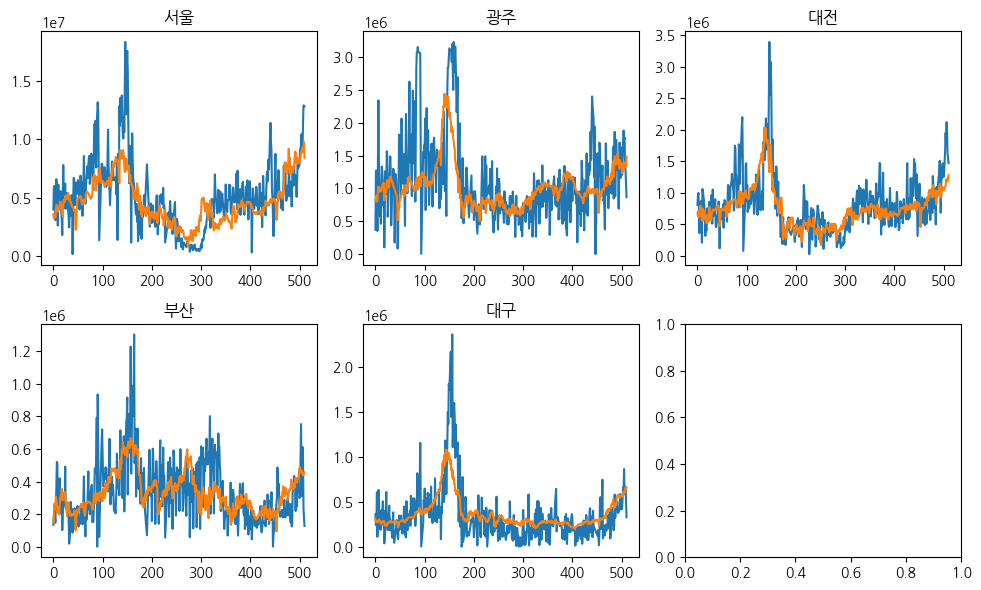

In [ ]:
# 모델 그래프 그리기
fig, axes = plt.subplots(2,3, figsize=(10, 6))

# 각 컬럼을 반복하면서 서브플롯에 그래프 그리기
for i, l in zip(range(5),loc):
    ax = axes.flat[i]
    ax.plot(res[l][2], label='Actual')
    ax.plot(res[l][3], label='Predicted')
    ax.set_title(l)


# 레이아웃 조정
plt.tight_layout()
plt.show()

In [ ]:
# 모델 결과 출력
rl=[]
for i in loc:
  rl.append(res[i][4:])
fin=pd.DataFrame(rl,columns=['mae','mse','rmse','r2'],index=res.keys())
fin

,mae,mse,rmse,r2
서울,1.625168e+06,4.821899e+12,2.195882e+06,0.431299
광주,3.621777e+05,2.859430e+11,5.347363e+05,0.268677
대전,2.240762e+05,1.010621e+11,3.179026e+05,0.502030
부산,1.190342e+05,2.491965e+10,1.578596e+05,0.256057
대구,1.571739e+05,5.145525e+10,2.268375e+05,0.473106


In [ ]:
# 실제값 예측값 파일로 저장
d=np.concatenate([res['대구'][1],res['대구'][3]],axis=0)
ind=list(data[data['도매지역']=='대구'].index)[80:]
rs=pd.Series(d.reshape(-1),index=ind)
rs.index.name='날짜'
rs.name='거래예측량'
pd.merge(data[data['도매지역']=='대구'][['도매지역','총거래물량']],rs,how='right',on='날짜').drop('도매지역',axis=1).to_csv('대구예측.csv',encoding='utf-8')